Timestep 900.0000 ss
Run time 2156.95s/35.95m


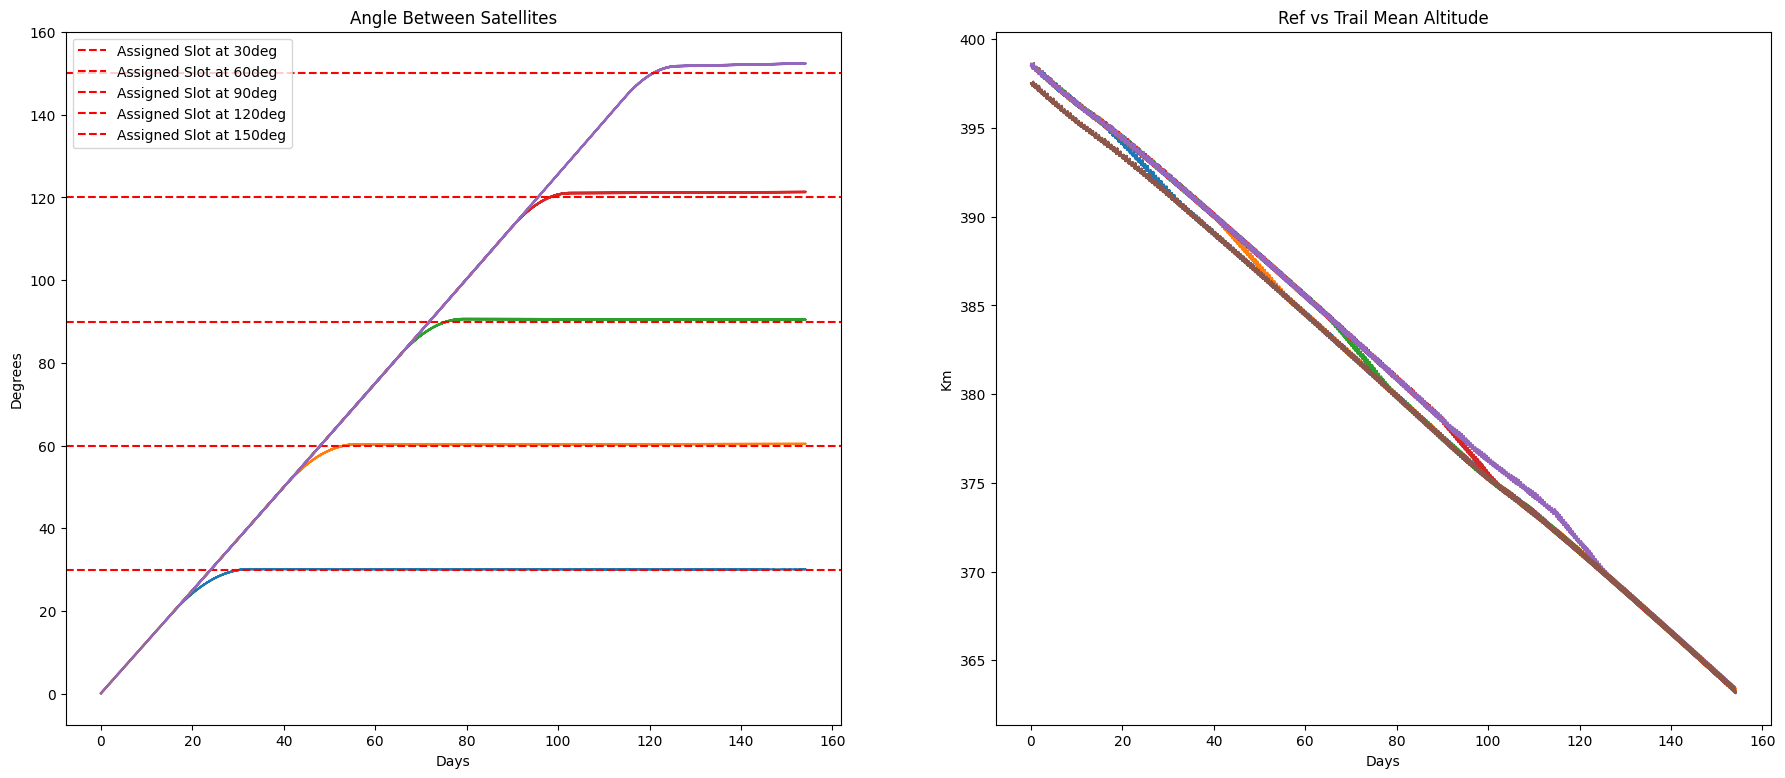

In [21]:
import time

import numpy as np

import matplotlib.pyplot as plt

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from osc2mean_dd import osc2mean
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high


toc = time.time()

## Orbit
h = 400
#alpha_wait = [0.75,0.9,0.93,0.96,0.95]
# alpha_hd = [4.4,4,3.8,3.3,3.1]
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

assignment = [30, 60, 90, 120, 150]                                                       
delta_a = [1, 1, 1, 1, 1]
delta_nu = [-0.1,-0.1,-0.1,-0.1, -0.1]

epoch = Time(val=start_date.isoformat(), format='isot')
time_step = 900<<u.s
pred_days = [40, 70, 100, 130, 160]

refsmalist = []
refsmalist_mean = []

trail_sats = 5

trailsmalist = [[] for i in range(trail_sats)]
trailsmalist_mean = [[] for i in range(trail_sats)]
elapsedsecs = [[] for i in range(trail_sats)]
angle_list = [[] for i in range(trail_sats)]

reference_orbit_list = []
trailing_orbit_list = []

start_date_prop = epoch

for sat in range(trail_sats):
    secs = 0

    reference_orbit = Orbit.from_classical(
        Earth,
        a,
        ecc,
        inc,
        raan,
        argp,
        nu,
        epoch
        )
    trailing_orbit = Orbit.from_classical(
        Earth,
        (a.value+delta_a[sat])<<u.km,
        ecc,
        inc,
        raan,
        argp,
        (nu.value+delta_nu[sat])<<u.deg,
        epoch
        )

    ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
    ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
    trail_mean = osc2mean(a.value+delta_a[sat], ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu[sat])
    trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu[sat]<<u.deg), epoch)

    theta_err = (assignment[sat] - argl_difference(reference_orbit, trailing_orbit))%360
    
    # tra_orb_pred = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    # tra_pred_mean = osc2mean(tra_orb_pred.a.value, tra_orb_pred.ecc.value, tra_orb_pred.inc.to_value(u.deg), tra_orb_pred.raan.to_value(u.deg), tra_orb_pred.argp.to_value(u.deg), tra_orb_pred.nu.to_value(u.deg))
    # tra_orb_pred_mean = Orbit.from_classical(Earth, tra_pred_mean[0]<<u.km, tra_pred_mean[1]<<u.one, tra_pred_mean[2]<<u.deg, tra_pred_mean[3]<<u.deg, tra_pred_mean[4]<<u.deg, tra_orb_pred.nu.to(u.deg), tra_orb_pred.epoch)
    # theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)

    tra_orb_pred_high = trailing_orbit.propagate(pred_days[sat]<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    tra_pred_mean_high = osc2mean(tra_orb_pred_high.a.value, tra_orb_pred_high.ecc.value, tra_orb_pred_high.inc.to_value(u.deg), tra_orb_pred_high.raan.to_value(u.deg), tra_orb_pred_high.argp.to_value(u.deg), tra_orb_pred_high.nu.to_value(u.deg))
    tra_orb_pred_mean_high = Orbit.from_classical(Earth, tra_pred_mean_high[0]<<u.km, tra_pred_mean_high[1]<<u.one, tra_pred_mean_high[2]<<u.deg, tra_pred_mean_high[3]<<u.deg, tra_pred_mean_high[4]<<u.deg, tra_orb_pred_high.nu.to(u.deg), tra_orb_pred_high.epoch)

    tra_orb_pred_low = trailing_orbit.propagate(pred_days[sat]<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
    tra_pred_mean_low = osc2mean(tra_orb_pred_low.a.value, tra_orb_pred_low.ecc.value, tra_orb_pred_low.inc.to_value(u.deg), tra_orb_pred_low.raan.to_value(u.deg), tra_orb_pred_low.argp.to_value(u.deg), tra_orb_pred_low.nu.to_value(u.deg))
    tra_orb_pred_mean_low = Orbit.from_classical(Earth, tra_pred_mean_low[0]<<u.km, tra_pred_mean_low[1]<<u.one, tra_pred_mean_low[2]<<u.deg, tra_pred_mean_low[3]<<u.deg, tra_pred_mean_low[4]<<u.deg, tra_orb_pred_low.nu.to(u.deg), tra_orb_pred_low.epoch)

    theta_dot_dot = (tra_orb_pred_mean_high.n.to(u.deg/u.s) - tra_orb_pred_mean_low.n.to(u.deg/u.s)) / ((pred_days[sat]*60*60*24)<<u.s)  



    t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
    theta_hd = 0.5 * theta_dot_dot * t_hd**2
    t_wait = ((theta_err - theta_hd.value) / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))) #- t_hd.value

    t_wait = t_wait     
    t_hd = t_hd

    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        if sat == trail_sats-1:
            refsmalist.append(ref_from_ephem.a.value)
        trailsmalist[sat].append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat == trail_sats-1:
            refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem, trail_from_ephem))

        elapsedsecs[sat].append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    num_hd = int(t_hd.value / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))


    for t in range(len(tofs_hd)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        if sat == trail_sats-1:
            refsmalist.append(ref_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean.append(ref_mean[0])


        trailsmalist[sat].append(trail_from_ephem.a.value)

        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )


        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem, trail_from_ephem))

        elapsedsecs[sat].append(secs)



    reference_orbit_list.append(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1]))
    trailing_orbit_list.append(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1]))



for sat in range(trail_sats):
    t_prop = ((elapsedsecs[-1][-1] - elapsedsecs[sat][-1]) + 60*60*24*7*4)<<u.s
    num_prop = int(t_prop.value / time_step.value)
    tofs_prop = TimeDelta(np.linspace(0, t_prop, num=num_prop))

    reference_ephem = reference_orbit_list[sat].to_ephem(EpochsArray(reference_orbit_list[sat].epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit_list[sat].to_ephem(EpochsArray(trailing_orbit_list[sat].epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))    

    for t in range(len(tofs_prop)):
        
        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])
    
        if sat == trail_sats-1:
            secs += time_step.value
            elapsedsecs[sat].append(secs)

            refsmalist.append(ref_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean.append(ref_mean[0])



        trailsmalist[sat].append(trail_from_ephem.a.value)

        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem, trail_from_ephem))

    reference_orbit_list.append(ref_from_ephem)
    trailing_orbit_list.append(trail_from_ephem)


elapsed_days = []

for sec in range(len(elapsedsecs[-1])):
    elapsed_days.append(elapsedsecs[-1][sec]/(60*60*24))

ref_mean_altitudes = []
for sma in range(len(refsmalist_mean)):
    ref_mean_altitudes.append(refsmalist_mean[sma] - Earth.R_mean.to_value(u.km))

trail_mean_altitudes = [[] for i in range(trail_sats)]
for sat in range(trail_sats):
    for sma in range(len(trailsmalist_mean[sat])):
        trail_mean_altitudes[sat].append(trailsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))


fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

for i in range(trail_sats):
    ax[0,0].plot(elapsed_days,angle_list[i])
    # ax[0,0].plot(elapsedsecs[1],angle_list[1])
    # ax[0,0].plot(elapsedsecs[2],angle_list[2])
    ax[0,0].axhline(assignment[i],linestyle='--',color='red',label = f'Assigned Slot at {assignment[i]}deg')
    # ax[0,0].axhline(assignment[1],linestyle='--',color='red',label = f'Assigned Slot at {assignment[1]}deg')
    # ax[0,0].axhline(assignment[2],linestyle='--',color='red',label = f'Assigned Slot at {assignment[2]}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

for i in range(trail_sats):
    ax[0,1].plot(elapsed_days,trail_mean_altitudes[i],label='Trail')
    # ax[0,1].plot(elapsedsecs[1],trail_mean_altitudes[1],label='Trail')
    # ax[0,1].plot(elapsedsecs[2],trail_mean_altitudes[2],label='Trail')
ax[0,1].plot(elapsed_days,ref_mean_altitudes,label='Ref')
ax[0,1].set_title('Ref vs Trail Mean Altitude')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

In [34]:
from poliastro.plotting import OrbitPlotter3D

frame_fin = OrbitPlotter3D()
frame_fin.plot(reference_orbit_list[-2], label = 'Ref', )
frame_fin.plot(trailing_orbit_list[-5], label = 'Trail_1')
frame_fin.plot(trailing_orbit_list[-4], label = 'Trail_2')
frame_fin.plot(trailing_orbit_list[-3], label = 'Trail_3')
frame_fin.plot(trailing_orbit_list[-2], label = 'Trail_4')
frame_fin.plot(trailing_orbit_list[-1], label = 'Trail_5')

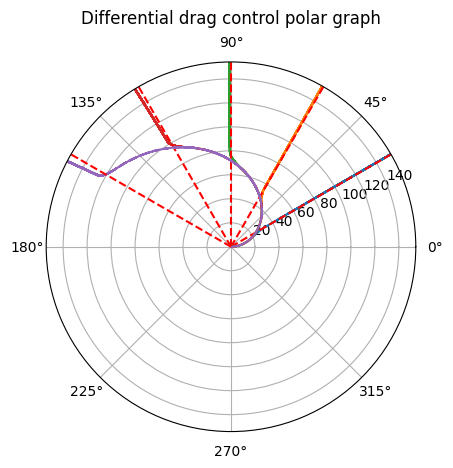

In [23]:
radians = [[] for i in range(trail_sats)]
rad_assignment = [[] for i in range(trail_sats)]
for sat in range(trail_sats):
    rad_assignment[sat].append(np.deg2rad(assignment[sat]))
    for deg in range(len(angle_list[sat])):
        radians[sat].append(np.deg2rad(angle_list[sat][deg]))
    for deg in range(len(angle_list[sat])-1):
        rad_assignment[sat].append(np.deg2rad(assignment[sat]))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for i in range(trail_sats):
    ax.plot(radians[i], elapsed_days)
    ax.plot(rad_assignment[i],elapsed_days,linestyle='--',color='red',label = f'Assigned Slot at {assignment[i]}deg')
ax.set_rmax(elapsed_days[-1])
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Differential drag control polar graph", va='bottom')
plt.show()

In [24]:
len(trailing_orbit_list)

10

In [41]:
prova_1 = trailing_orbit_list[-5].propagate(420<<u.s, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
prova_2 = trailing_orbit_list[-4].propagate(120<<u.s, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
prova_3 = trailing_orbit_list[-3].propagate(120<<u.s, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
prova_5 = trailing_orbit_list[-1].propagate(12120<<u.s, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))

In [42]:
from poliastro.plotting import OrbitPlotter3D

frame_fin = OrbitPlotter3D()
frame_fin.plot(reference_orbit_list[-2], label = 'Ref', )
frame_fin.plot(prova_1, label = 'Trail_1')
frame_fin.plot(prova_2, label = 'Trail_2')
frame_fin.plot(prova_3, label = 'Trail_3')
frame_fin.plot(trailing_orbit_list[-2], label = 'Trail_4')
frame_fin.plot(prova_5, label = 'Trail_5')

In [53]:
reference_orbit_list[-2].rv()

(<Quantity [-3408.502113  , -4988.05124236, -2984.47845356] km>,
 <Quantity [-2.77184736, -2.19738375,  6.83058437] km / s>)